# 2D Annotations of Molecules 

## Introduction
The goal of this project is to render a 2 dimensional molecular drawing (png file) with annotations detailing a specific feature per atom. 

This example uses 2,6-Dichloropyridine as an input.

## Dependencies
1. IOData
2. Numpy
3. RDKit
5. CHEMML 
6. Pandas
7. Glob 
8. OS 


In [1]:
# import required libraries
from iodata import load_one, dump_one

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Atom
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem.Draw import DrawingOptions

from IPython.display import Image

from chemml.chem import Molecule

import pandas as pd
import glob
import os

## Manipulation of Input and Extraction of Charges 

We first want to open our file using IOData, designated `loadInput`, from then we can extract informations related to the `.fchk` file using IOData to annotate our molecule.

Then we can use `dump_one` to output two files, one XYZ file and one PDB File.  

In [2]:
inputName = 'dichloropyridine26_q+0.fchk' # EDIT THIS TO CHANGE MOLECULE
loadInput = load_one(inputName) 

xyzName = 'dichloropyridine26_q+0.xyz'    # EDIT THIS TO CHANGE INTERMEDIATE XYZ FILE
pdbName = 'dichloropyridine_q+0.pdb'    # EDIT THIS TO CHANGE INTERMEDIATE PDB FILE 
molName = xyzName[:-4]
imageName = f"{molName}.png" 

print("Molecule Name : ")
print(molName)
print(" ")

dump_one(loadInput,pdbName)     # DUMP XYZ
dump_one(loadInput, xyzName)    # DUMP PDB
espCharges = loadInput.atcharges['esp'][:]  # IOData ESP CHARGES 

Molecule Name : 
dichloropyridine26_q+0
 


## Manipulate Molecule to Create MOL Object
We need to dump our IOData loaded molecule into an `.xyz` file, which can then be parsed using `CHEMML`, to create a data table containing basic information such as filename, XYZ Cartesian Coordinates, and the SMILES equivalent of the molecule.


PDB Files maintain the same atomic order as IOData, however, pi bonds cannot visualize properly, due to the fact that PDB files enumerate pi bonds through the distance between atoms in cartesian space, whereas RDKit prefers that bonds are explicitly mentioned.

We can exploit this by extracting the SMILES representation of 2,6-Dichloropyridine from our XYZ File. This is accomplished by enumerating every molecule within the XYZ file using `for molecule in molecule_list:`, then tabulating the molecules into a Pandas DataFrame `table`, then extracting the SMILES string.

With regards to the PDB File, we can exploit the way the PDB enumerates atoms, and use `AllChem.AssignBondOrdersFromTemplate` to force the PDB to visualize as the SMILES string, which serves as our template molecule, resulting in object `tempMol` 

Then we can iterate through every atom in the forced assignment and label each atom using `atom.SetProp()` 

[<chemml.chem.Molecule(
        rdkit_molecule : <rdkit.Chem.rdchem.Mol object at 0x7f351eb7bad0>,
        pybel_molecule : <openbabel.pybel.Molecule object at 0x7f351eb97250>,
        creator        : ('XYZ', 'dichloropyridine26_q+0.xyz'),
        smiles         : 'Clc1cccc(Cl)n1',
        smarts         : None,
        inchi          : None,
        xyz            : <XYZ(geometry: (11, 3), atomic_numbers: (11, 1), atomic_symbols: (11, 1))>)>]
 

                         Name          SMILES
0  dichloropyridine26_q+0.xyz  Clc1cccc(Cl)n1
 
Our Molecule in SMILES format: 
Clc1cccc(Cl)n1
 
-0.119822758
-0.119828567
-0.538243531
0.260573695
-0.453200648
-0.4532028
0.499768812
0.499772652


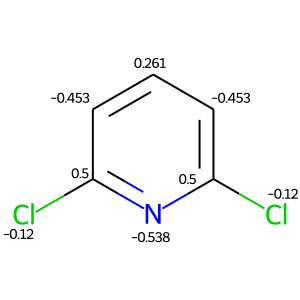

In [3]:
xyz_files = glob.glob(xyzName)
mol = Molecule('dichloropyridine26_q+0.xyz', 'xyz')

# make a list of ChemML Molecule object instances based on the names of the xyz files from xyz_files
molecule_list = [Molecule(xyzName, input_type='xyz') for file in xyz_files]

# alter the ChemML Molecule object instances of molecule_list so that their SMILES codes can be recognzied by RDKit
for molecule in molecule_list:
    molecule.to_smiles()

print(molecule_list)

table = pd.DataFrame(data={'Name':xyzName,  
                         'SMILES':[molecule.smiles for molecule in molecule_list]}, 
                   columns=['Name','SMILES'])

print(" ")
print("")
print(table)

print(" ")
smiles = table.iloc[0,1]
print("Our Molecule in SMILES format: ")
print(smiles)
print(" ")


chem = Chem.MolFromPDBFile(pdbName, sanitize=True)
template = Chem.MolFromSmiles(smiles)
AllChem.Compute2DCoords(chem)
tempMol = AllChem.AssignBondOrdersFromTemplate(template,chem)

def imageMolecule(chem,imageName):
    """
    This function consolidates all calls done to generate the desired image
    """
    
    drawMolecule = rdMolDraw2D.MolDraw2DCairo(300, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(drawMolecule, chem)
    drawMolecule.drawOptions().addStereoAnnotation = True
    
    for i, atom in enumerate(tempMol.GetAtoms()):
        atom.SetProp("atomNote", f"{np.round(float(espCharges[i]),3)}")
        print(espCharges[i])
    
    Chem.Draw.MolToFile(tempMol,imageName)


imageMolecule(tempMol,imageName)

Image(imageName)

## 2D Annotations Consolidated as a Function

The afforementioned annotations have been consolidated into a function below for ease of use

In [5]:
from iodata import load_one, dump_one
    
import glob
import os
    
import numpy as np
import pandas as pd
    
from chemml.chem import Molecule

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Atom
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem.Draw import DrawingOptions
    
def annotation2D(inputName):
    """
    This function is designed to consolidate what is necessary to use RDKit to visualize molecular data onto a 2D representation of a molecule
    
    Conda Environment
    -----------------
        This function requires a conda environment containing
            1. Pandas
            2. Numpy
            3. Glob
            4. OS
            5. Chemml
            6. RDKit 
    Yields
    ------
        This function produces a PNG image of our input molecule (inFile), annotated with our assigned values (annotateValue)
    Parameters
    ----------
        inputName, str
            The file name of the Gaussian Checkpoint *.fchk file that will be processed
        
        annotateValue : IOData Call
            This represents the value that we want to annotate our molecule with.
            While annotateValue does not necessarily need to be an IOData Call, this example uses IOData's atcharges['esp'][:]
            IOData Examples can be found here
            
                https://iodata.readthedocs.io/en/latest/index.html
            
        xyzName, str
            Derived from inputName
            This represents the name of the intermediate XYZ File in which the SMILES format is extracted from
            
        pdbName, str
            Derived from inputName
            This represents the name of the intermediate PDB File in which the atomic indices are preserved for annotation
      
        molName, str
            Derived from xyzName
            This represents the name of the molecule
        
        imageName, str
            Derived from molName
            This represents the name of the annotated image. 
            
        xyz_files, glob
            This is meant to find all relevant XYZ Files
        
        mol and molecule_list, chemml object
            This is the loaded XYZ file, and will be tabulated in order to find the SMILES String
       
        table, Pandas DataFrame
            Tabulated format allowing us to extract the SMILES String from the chemml object
            
        smiles, str
            This represents the extracted SMILES string from our XYZ intermediate file
            
        chem, RDKit mol object 
            This represents our intermediate PDB loaded into RDKit 
        
        template, RDKit mol object
            This represents our SMILES string (originally from XYZ intermediate) loaded into RDKit 
       
        tempMol, corrected RDKit mol object
            This represents our PDB Corrected using the XYZ SMILES String
            This is accomplished by using AllChem.AssignBondOrdersFromTemplate
     
        drawMolecule, RDKit mol object visualization
            This represents our RDKit object being visualized
            MolDraw2DCairo is used to output to PNG
            
    -------------- 
    End Parameters
    """
    
    loadInput = load_one(inputName) 

    xyzName = f"{inputName[:-4]}xyz"    # EDIT THIS TO CHANGE INTERMEDIATE XYZ FILE
    pdbName = f"{inputName[:-4]}pdb"    # EDIT THIS TO CHANGE INTERMEDIATE PDB FILE 
    molName = xyzName[:-4]
    imageName = f"{molName}.png" 

    print("Molecule Name : ")
    print(molName)
    print(xyzName)

    dump_one(loadInput,pdbName)     # DUMP XYZ
    dump_one(loadInput, xyzName)    # DUMP PDB
   
    # EDIT annotateValue TO CHANGE ANNOTATIONS 
    annotateValue = loadInput.atcharges['esp'][:] #EDITABLE 

    # Extract SMILES String from XYZ Intermediate
    xyz_files = glob.glob(xyzName)
    mol = Molecule('dichloropyridine26_q+0.xyz', 'xyz')

    molecule_list = [Molecule(xyzName, input_type='xyz') for file in xyz_files]
    for molecule in molecule_list:
            molecule.to_smiles()
    print(molecule_list)
    table = pd.DataFrame(data={'Name':xyzName,  
                         'SMILES':[molecule.smiles for molecule in molecule_list]}, 
                   columns=['Name','SMILES'])

    print(" ")
    print(table)
    print(" ")
        
    smiles = table.iloc[0,1]
    print("Our Molecule in SMILES format: ")
    print(smiles)
    print(" ")
    
    # Force PDB Intermediate Bond Orders to SMILES String 
    chem = Chem.MolFromPDBFile(pdbName, sanitize=True)
    template = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(chem)
    tempMol = AllChem.AssignBondOrdersFromTemplate(template,chem)

    # Visualize Molecule
    
    drawMolecule = rdMolDraw2D.MolDraw2DCairo(300, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(drawMolecule, chem)
    drawMolecule.drawOptions().addStereoAnnotation = True
    
    # Annotate Molecule
    for i, atom in enumerate(tempMol.GetAtoms()):
        atom.SetProp("atomNote", f"{np.round(float(annotateValue[i]),3)}") 
    
    # Output Visualization to File
    Chem.Draw.MolToFile(tempMol,imageName) 
    print(" ")
    print(f"The molecule {molName} has been annotated and output as file {imageName}")
    print(" ")
    #END FUNCTION 

In [6]:

inputName = 'acrolein_q+0.fchk'
annotation2D(inputName)


Molecule Name : 
acrolein_q+0
acrolein_q+0.xyz
[<chemml.chem.Molecule(
        rdkit_molecule : <rdkit.Chem.rdchem.Mol object at 0x7f351eb405d0>,
        pybel_molecule : <openbabel.pybel.Molecule object at 0x7f351ebd8b90>,
        creator        : ('XYZ', 'acrolein_q+0.xyz'),
        smiles         : 'C=CC=O',
        smarts         : None,
        inchi          : None,
        xyz            : <XYZ(geometry: (8, 3), atomic_numbers: (8, 1), atomic_symbols: (8, 1))>)>]
 
               Name  SMILES
0  acrolein_q+0.xyz  C=CC=O
 
Our Molecule in SMILES format: 
C=CC=O
 
 
The molecule acrolein_q+0 has been annotated and output as file acrolein_q+0.png
 
